In [1]:
import torch
import torch.nn.functional as F
from cirkit.templates import data_modalities, utils

KERNEL_SIZE = (4, 4)
STRIDE = KERNEL_SIZE
gpu_id = 5

## Data Setup

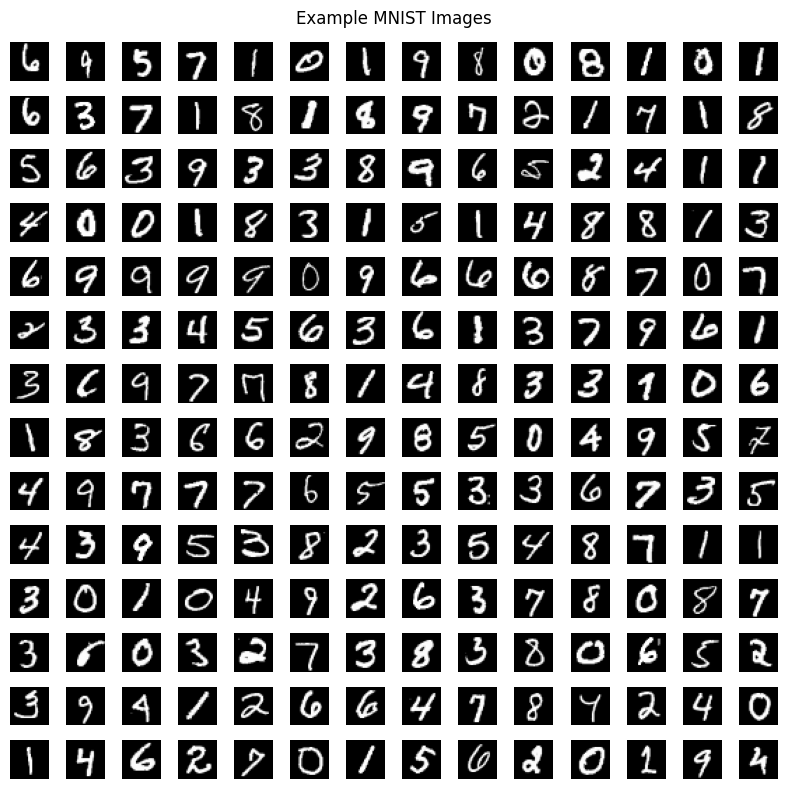

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

PIXEL_RANGE = 255
# Store an example image
example_image = None


def unpatchify(
    image_size: tuple[int, int],
    kernel_size: tuple[int, int],
    stride: tuple[int, int],
    channel: int,
):
    H, W = image_size
    kh, kw = kernel_size
    sh, sw = stride

    def _unpatchify(patches: torch.Tensor):
        """
        patches: (N_patches_total, C*kh*kw) or (N_patches_total, C, kh, kw)
        image_size: (H, W)
        kernel_size: (kh, kw)
        stride: (sh, sw)
        channel: number of channels C
        Returns: (N_images, C, H, W) tensor (float)
        """
        if patches.dim() == 2:
            # flatten -> (N, C, kh, kw)
            patches = patches.view(-1, channel, kh, kw)

        Bpatch = patches.shape[0]

        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1
        patches_per_image = Lh * Lw
        assert Bpatch % patches_per_image == 0, (
            "Total patches not divisible by patches_per_image"
        )

        n_images = Bpatch // patches_per_image
        patches = patches.view(n_images, patches_per_image, channel, kh, kw)

        images = torch.zeros(
            (n_images, channel, H, W), dtype=patches.dtype, device=patches.device
        )

        idx = 0
        for ih in range(Lh):
            for iw in range(Lw):
                patch_idx = ih * Lw + iw
                h0 = ih * sh
                w0 = iw * sw
                images[:, :, h0 : h0 + kh, w0 : w0 + kw] = patches[:, patch_idx]
        return images

    return _unpatchify


def patchify(kernel_size, stride, compile=True, contiguous_output=False):
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride

    def _patchify(image: torch.Tensor):
        # Accept (C,H,W) or (B,C,H,W)

        # Ensure contiguous NCHW for predictable strides
        x = image.contiguous()  # (B,C,H,W)
        C, H, W = x.shape

        # Number of patches along H/W
        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1

        # Create a zero-copy view: (B, C, Lh, Lw, kh, kw)
        sC, sH, sW = x.stride()
        patches = x.as_strided(
            size=(C, Lh, Lw, kh, kw),
            stride=(sC, sH * sh, sW * sw, sH, sW),
        )
        # Reorder to (B, P, C, kh, kw) where P = Lh*Lw
        patches = patches.permute(1, 2, 0, 3, 4).reshape(Lh * Lw, C, kh, kw)

        if contiguous_output:
            patches = (
                patches.contiguous()
            )  # materialize if the next ops need contiguous

        return patches

    # if compile:
    #     _patchify = torch.compile(_patchify, fullgraph=True, dynamic=False)
    return _patchify


def collate_patches(batch):
    batched_patch = []
    batched_label = []

    num_patch = batch[0][0].shape[0]
    for tensor, label in batch:
        batched_label.extend([label for _ in range(num_patch)])

        batched_patch.extend(tensor.unbind(0))
    # (B,P,C,H,W) -> (BxP,C,H,W)
    return torch.stack(batched_patch), batched_label


# Load the MNIST data set and data loaders
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Set pixel values in the [0-255] range
        # patchify(KERNEL_SIZE, STRIDE),
        transforms.Lambda(lambda x: (PIXEL_RANGE * x).long()),
    ]
)


# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, label = next(iter(dataloader))
    example_image = images[0]
    images = images[: gridsize**2]

    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i, :, :].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Turn off axis

    # Adjust spacing between subplots
    fig.suptitle("Example MNIST Images")
    plt.tight_layout()
    plt.show()

def plot_patch_images(images, gridsize=4):
    # Get the first batch of images and labels
    images = images[: gridsize**2]

    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i, :, :].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Turn off axis

    # Adjust spacing between subplots
    fig.suptitle("Example MNIST Patch")
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST("datasets", train=True, download=True, transform=transform)
data_test = datasets.MNIST("datasets", train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(
    data_train, shuffle=True, batch_size=256, collate_fn=collate_patches
)
test_dataloader = DataLoader(
    data_test, shuffle=False, batch_size=256, collate_fn=collate_patches
)
# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=14)

torch.Size([49, 1, 4, 4])


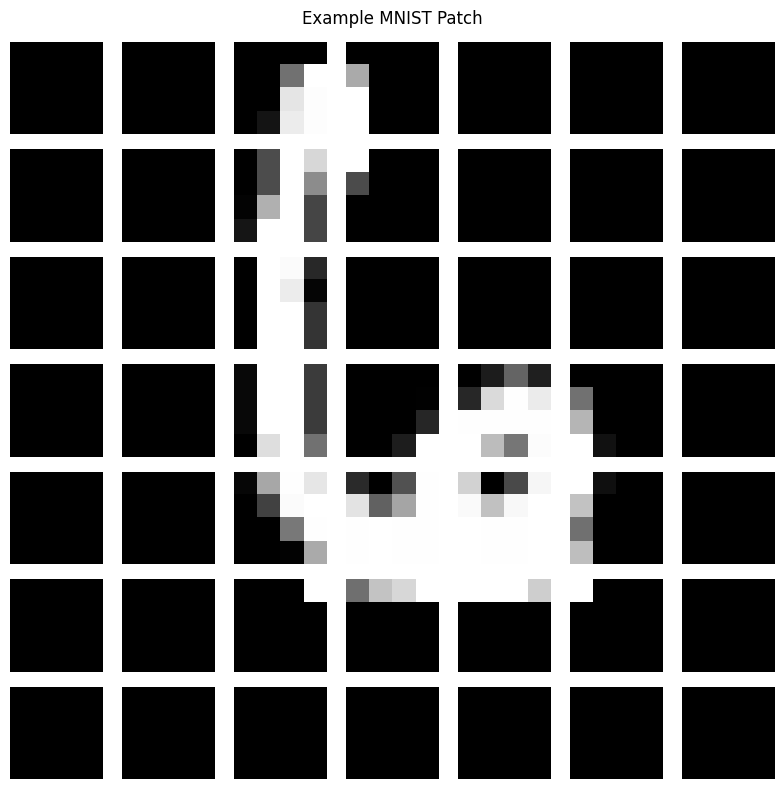

In [12]:
patcher = patchify(KERNEL_SIZE, STRIDE)
unpatcher = unpatchify((28, 28), KERNEL_SIZE, KERNEL_SIZE, 1)
patched = patcher(example_image.unsqueeze(0))
print(patched.shape)
plot_patch_images(patched, 7)

torch.Size([1, 1, 28, 28])

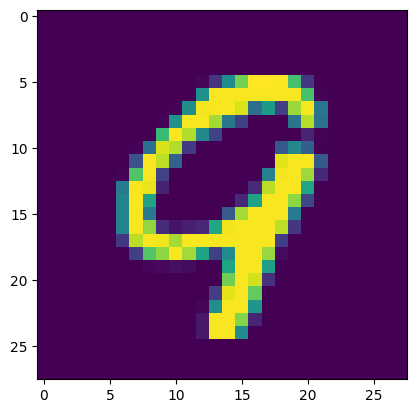

In [21]:
unpatched = unpatcher(inputd)
plt.imshow(unpatched[0][0])
unpatched.shape

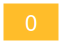

In [26]:
from cirkit.symbolic.io import plot_circuit

circuit = data_modalities.image_data(
    (1, 1, 1),
    region_graph="quad-graph",
    input_layer="categorical",
    num_input_units=64,
    sum_product_layer="cp",
    num_sum_units=1,
    sum_weight_param=utils.Parameterization(
        activation="softmax", initialization="normal"
    ),
)
plot_circuit(circuit)

In [27]:
from cirkit.pipeline import compile

comp_circ = compile(circuit)
comp_circ(torch.randint(0, 255, (1, 4)))

tensor([[[-6.8969, -5.8032, -6.4871, -4.1566, -5.8537, -5.6068, -5.5692,
          -7.4597, -5.3299, -7.3458, -5.7403, -6.6552, -8.0185, -6.4412,
          -7.7747, -6.9117, -5.6548, -6.0225, -5.3716, -6.0571, -5.5803,
          -4.9458, -3.4900, -6.1547, -3.8321, -7.6126, -4.9319, -5.2625,
          -5.7230, -5.5452, -5.3310, -5.6161, -7.6718, -6.4249, -6.8247,
          -7.5280, -5.2097, -4.6821, -6.1548, -6.6439, -4.9449, -7.4194,
          -7.1167, -6.6237, -6.3598, -6.2386, -4.7509, -6.1965, -6.8211,
          -6.4616, -5.9482, -6.5263, -5.2896, -7.1176, -8.5361, -7.0446,
          -6.5932, -5.4539, -5.7435, -5.5624, -5.2663, -8.5962, -7.6707,
          -6.1567]]], grad_fn=<TransposeBackward0>)

In [88]:
import random

from cirkit.pipeline import compile


def train_circuit(cc):
    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)

    # Set the torch device to use
    device = torch.device(f"cuda:{gpu_id}")

    # Compile the circuit
    circuit = compile(cc)

    # Move the circuit to chosen device
    circuit = circuit.to(device)

    num_epochs = 10
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats["# trainable parameters"] = sum(
        p.numel() for p in circuit.parameters() if p.requires_grad
    )
    stats["train loss"] = []

    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)

    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)

            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)

            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 200 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0

                stats["train loss"].append(average_nll.cpu().item())
    return stats, circuit


stats, t_circuit = train_circuit(circuit)
stats

Step 200: Average NLL: 51.610
Step 400: Average NLL: 18.951
Step 600: Average NLL: 16.763
Step 800: Average NLL: 15.937
Step 1000: Average NLL: 15.541
Step 1200: Average NLL: 15.334
Step 1400: Average NLL: 15.213
Step 1600: Average NLL: 15.165
Step 1800: Average NLL: 15.073
Step 2000: Average NLL: 15.062
Step 2200: Average NLL: 15.045


{'# trainable parameters': 508546,
 'train loss': [51.61037826538086,
  18.9510440826416,
  16.762956619262695,
  15.9368314743042,
  15.540987968444824,
  15.334369659423828,
  15.213346481323242,
  15.165040969848633,
  15.072599411010742,
  15.061633110046387,
  15.045388221740723]}

In [ ]:
def eval_circuit(circuit):
    circuit = circuit.to()
    with torch.no_grad():
        test_lls = 0.0

        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            # (BxP,C,H,W) -> # (B,P,C,H,W)
            batch = batch.view(BS, -1).to(f"cuda:{gpu_id}")
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)

            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()

        # Compute average test log-likelihood and bits per dimension
        average_nll = -test_lls / len(data_test)

        bpd = average_nll / (28 * 28 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")

        stats["test loss"] = average_nll
        stats["test bits per dimension"] = bpd

    # Free GPU memory
    circuit = circuit.to("cpu")
    torch.cuda.empty_cache()

    stats["train loss (min)"] = min(stats["train loss"])
    return stats


eval_circuit(t_circuit)

Average test LL: 731.456
Bits per dimension: 1.346


{'# trainable parameters': 508546,
 'train loss': [51.61037826538086,
  18.9510440826416,
  16.762956619262695,
  15.9368314743042,
  15.540987968444824,
  15.334369659423828,
  15.213346481323242,
  15.165040969848633,
  15.072599411010742,
  15.061633110046387,
  15.045388221740723],
 'test loss': 731.456281640625,
 'test bits per dimension': np.float64(1.3460055486607279),
 'train loss (min)': 15.045388221740723}